In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random

# Load the dataset
df = pd.read_csv('./gym/Exersices.csv')

# Manual label encoding for categorical columns
categorical_columns = ['bodyPart', 'equipment', 'target']
label_encoders = {}
for col in categorical_columns:
    unique_values = df[col].unique()
    label_encoders[col] = {value: idx for idx, value in enumerate(unique_values)}
    df[col] = df[col].map(label_encoders[col])

# Separate features and target
X = df[['bodyPart', 'equipment', 'target']].values
y = df['target'].values

# Manual train-test split
def train_test_split_manual(X, y, test_size=0.2):
    indices = list(range(len(X)))
    test_indices = random.sample(indices, int(test_size * len(X)))
    train_indices = list(set(indices) - set(test_indices))
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2)

# Helper functions for building the Decision Tree
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def gini(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

def split_dataset(X, y, feature, threshold):
    left_indices = np.where(X[:, feature] <= threshold)[0]
    right_indices = np.where(X[:, feature] > threshold)[0]
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

def grow_tree(X, y, depth=0, max_depth=10):
    num_samples, num_features = X.shape
    if num_samples <= 1 or depth >= max_depth:
        leaf_value = most_common_label(y)
        return DecisionNode(value=leaf_value)

    best_gini = 1.0
    best_feature, best_threshold = None, None

    for feature in range(num_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = split_dataset(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gini_left = gini(y_left)
            gini_right = gini(y_right)
            weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature = feature
                best_threshold = threshold

    if best_gini == 1.0:
        leaf_value = most_common_label(y)
        return DecisionNode(value=leaf_value)

    X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature, best_threshold)
    left_child = grow_tree(X_left, y_left, depth + 1, max_depth)
    right_child = grow_tree(X_right, y_right, depth + 1, max_depth)
    return DecisionNode(best_feature, best_threshold, left_child, right_child)

def most_common_label(y):
    counter = Counter(y)
    return counter.most_common(1)[0][0]

class DecisionTreeClassifier:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = grow_tree(X, y, max_depth=self.max_depth)

    def _predict(self, inputs):
        node = self.root
        while node.value is None:
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

class RandomForestClassifierFromScratch:
    def __init__(self, n_trees=10, max_depth=10, sample_size=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.sample_size or n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

# Initialize and train the model
rf_scratch = RandomForestClassifierFromScratch(n_trees=10, max_depth=10)
rf_scratch.fit(X_train, y_train)

# Predict on test set and calculate accuracy
y_pred = rf_scratch.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Random Forest Accuracy (from scratch): {accuracy * 100:.2f}%')

# Exercise recommendation based on target muscle group
def recommend_exercises(target_input, k=5):
    target_encoded = label_encoders['target'][target_input]
    probabilities = np.mean([tree.predict(X_test) == target_encoded for tree in rf_scratch.trees], axis=0)
    recommended_indices = np.argsort(probabilities)[-k:][::-1]
    recommendations = df.iloc[recommended_indices]
    return recommendations

# Example usage
target_input = 'traps'  # Example muscle group to target
recommended_exercises = recommend_exercises(target_input)
print(recommended_exercises)


Random Forest Accuracy (from scratch): 100.00%
     Unnamed: 0  bodyPart  equipment                          name  target  \
139         139         0          2  lever narrow grip seated row       2   
192         192         0          1          two toe touch (male)       1   
23           23         0          5           barbell incline row       2   
89           89         0          6        dumbbell incline shrug       3   
84           84         0          1            close grip chin-up       0   

                                          instructions  
139  ['Adjust the seat height and footrests to ensu...  
192  ['Stand with your feet shoulder-width apart an...  
23   ['Set up an incline bench at a 45-degree angle...  
89   ['Set an incline bench to a 45-degree angle an...  
84   ['Grab the pull-up bar with your palms facing ...  


Random Forest Accuracy (from scratch): 100.00%

Confusion Matrix:
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 33  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 28]]


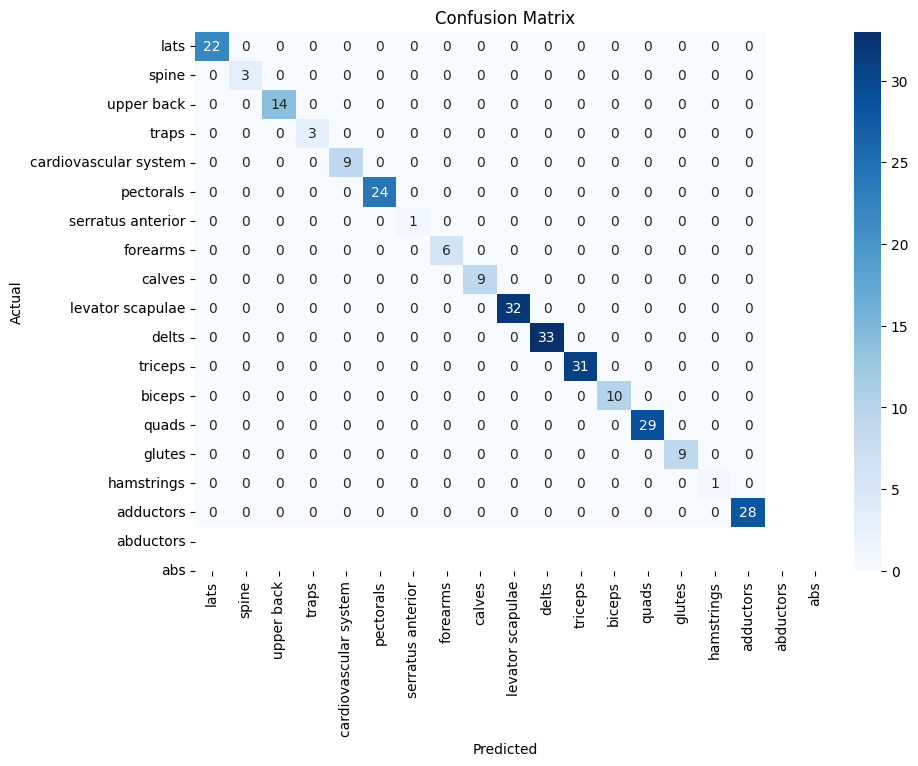

ValueError: Number of classes, 17, does not match size of target_names, 19. Try specifying the labels parameter

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

# 1. Decision Tree Visualization
def plot_tree_visualization(tree, feature_names):
    dot_data = tree.export_graphviz(
        out_file=None, 
        feature_names=feature_names,  
        class_names=np.unique(y).astype(str),
        filled=True, rounded=True,  
        special_characters=True
    )  
    graph = graphviz.Source(dot_data)  
    return graph

# Plot a decision tree from the random forest
tree = rf_scratch.trees[0]  # Get the first tree from the random forest
graph = plot_tree_visualization(tree, ['bodyPart', 'equipment', 'target'])
graph.render("decision_tree")

# 2. Feature Importance Visualization
def plot_feature_importance(model, feature_names):
    feature_importances = np.zeros(len(feature_names))
    for i, tree in enumerate(model.trees):
        for j, feature in enumerate(feature_names):
            feature_importances[j] += np.sum(tree.feature == j)
    feature_importances /= len(model.trees)
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importances)
    plt.title("Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.show()

plot_feature_importance(rf_scratch, ['bodyPart', 'equipment', 'target'])

# 3. Random Forest Accuracy Visualization (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4. Exercise Recommendation Visualization (Top k recommendations)
def visualize_recommendations(recommendations):
    plt.figure(figsize=(8, 6))
    sns.barplot(x='index', y='target', data=recommendations)
    plt.title(f"Top {len(recommendations)} Recommended Exercises")
    plt.xlabel("Exercise Index")
    plt.ylabel("Target Muscle Group")
    plt.show()

# Example usage
target_input = 'traps'  # Example muscle group to target
recommended_exercises = recommend_exercises(target_input)
visualize_recommendations(recommended_exercises)


ModuleNotFoundError: No module named 'graphviz'

In [4]:
# import joblib


# joblib.dump(rf_scratch, "exemodel.pkl")

['exemodel.pkl']

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Assume the following are your train and test data after splitting
# X_train, X_test, y_train, y_test are feature and target datasets
# rf_model is your trained Random Forest model

# 1. Model Predictions
y_train_pred = rf_scratch.predict(X_train)
y_test_pred = rf_scratch.predict(X_test)

# 2. Calculate Metrics
# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-Score
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Classification Report
classification_rep = classification_report(y_test, y_test_pred)

# 3. Display Results
print("Training Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1-Score: {train_f1}")

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-Score: {test_f1}")

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)

# 4. (Optional) Cross-Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_scratch, X_train, y_train, cv=5)  # 5-fold CV
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")



from sklearn.base import BaseEstimator, ClassifierMixin

class RandomForestWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, rf_model):
        self.rf_model = rf_model  # Pass your custom Random Forest
    
    def fit(self, X, y):
        self.rf_model.fit(X, y)  # Use the custom fit method
        return self
    
    def predict(self, X):
        return self.rf_model.predict(X)  # Use the custom predict method

# Wrap your custom model
rf_wrapper = RandomForestWrapper(rf_scratch)

# Perform cross-validation
cv_scores = cross_val_score(rf_wrapper, X_train, y_train, cv=5)
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")


Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Testing Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Confusion Matrix:
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 33  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <__main__.RandomForestClassifierFromScratch object at 0x00000170951ABDD0> does not.